# **Práctica 10: Regresión Lasso y Ridge**

En esta práctica entrenaremos modelos de Regresión Ridge y Regresión Lasso con un enfoque en la selección del hiperparámetro de regularización (α) y la comparación del rendimiento de ambos modelos.

El objetivo es entender cómo la regularización afecta a los coeficientes y el rendimiento, particularmente en escenarios con multicolinealidad o sobreajuste.

## **Librerías necesarias**

In [22]:
# Importación de datos
# =========================================================================================
from google.colab import drive
from pathlib import Path

# Tratamientod de datos
# =========================================================================================
import numpy as np
import pandas as pd

# Preprocesado y Modelado
# =========================================================================================
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Gráficos
# ==========================================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración de Gráficos
# ==========================================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
sns.set_theme()

# Configuración Warnings
# ===========================================================================================
import warnings
warnings.filterwarnings('ignore')

## **1. Importación de datos y EDA**

### **Importación del CSV de datos a través de Google Drive**

Utilizaré la librería de google para poder montar mi drive y con la librería `pathlib` para definir la ruta de mi archivo y montarlo en un `DataFrame` de Pandas.

In [23]:
# Montamos el drive para traernos "data.csv" al cuadernillo
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
def carga_dataframe(path: Path):
  """
  Función para cargar un DataFrame desde un archivo CSV
  :param path: Ruta del archivo CSV
  :return: DataFrame con los datos
  """
  data = pd.read_csv(path)
  print("\nLa carga de los datos ha sido satisfactoria.")

  # Devuelvo el dataframe a través de la función
  return data

In [25]:
# Creo la ruta del archivo para poder importar el CSV del ejercicio
regular_path = Path("/content/drive/MyDrive/TS - Machine Learning")
data_path = regular_path / "M3_Interpretacion_Mejora_Modelos" / "3.3 Modelos de regresion regularizado" / "company.csv"

In [26]:
# Utilizo la función definida arriba para traerme el CSV desde la ruta a su ubicación a Colab

df = carga_dataframe(data_path)
df.head() # Primer vistazo a los datos


La carga de los datos ha sido satisfactoria.


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


### **EDA y preparación de los datos**

In [27]:
def analizar_data(data: pd.DataFrame, target: str):
  """
  Función para sacar un análisis exploratorio de los datos
  :param data: DataFrame con los datos
  :return: None
  """
  # Imprimimos por pantalla el conteo de filas y columnas con el tipo de dato de estas
  conteo_filas_columnas_tiposdato(data)

  # Imprimimos por pantalla las columnas que tengan nulos
  analizar_nulos(data)

  # Finalmente sacamos un data.describe() para ver las estadísticas básicas
  print("\n📊 Análisis estadístico de los datos:")
  print(data.describe())
  print("\n")


def conteo_filas_columnas_tiposdato(data: pd.DataFrame):
  """
  Función para sacar el conteo de filas, columnas y tipos de dato de un DataFrame
  :param data: DataFrame con los datos
  :return: None
  """
  # Sacamos el número de filas, el de columnas
  print("Nº filas: " + str(data.shape[0]))
  print("Nº columnas: " + str(data.shape[1]))

  # Imprimimos por pantalla el nombre de las columnas y el tipo de dato que tienen
  print("\nNombre de columnas y tipo de dato de estas:")
  print(data.dtypes)


def analizar_nulos(data: pd.DataFrame):
  """
  Función para analizar los nulos de un DataFrame
  :param data: DataFrame con los datos
  :return: None
  """

  nulos = data.isnull().sum() # Cálculo de nulos
  ratio = (nulos/data.shape[0]) * 100 # Cálculo de ratios

  resumen = pd.DataFrame({
      'Nulos': nulos,
      'Ratio (%)': ratio
  })

  print("\n🗒️ Análisis de valores nulos:")
  print(resumen)

  print("\nNúmero de filas del DataFrame duplicadas:")
  print(data.duplicated().sum())


In [28]:
# Separo la variable target del resto de caracteristicas
TARGET_COL = "Sales"
FEATURE_COLS = [col for col in df.columns if col != TARGET_COL]

In [29]:
# Llamo a la función de análisis
analizar_data(df, TARGET_COL)

Nº filas: 200
Nº columnas: 4

Nombre de columnas y tipo de dato de estas:
TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

🗒️ Análisis de valores nulos:
           Nulos  Ratio (%)
TV             0        0.0
Radio          0        0.0
Newspaper      0        0.0
Sales          0        0.0

Número de filas del DataFrame duplicadas:
0

📊 Análisis estadístico de los datos:
               TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   15.130500
std     85.854236   14.846809   21.778621    5.283892
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   11.000000
50%    149.750000   22.900000   25.750000   16.000000
75%    218.825000   36.525000   45.100000   19.050000
max    296.400000   49.600000  114.000000   27.000000




Los datos de este DataFrame vienen bastante límpios en términos de datos nulos, filas repetidas y demás.

### **Análisis gráfico de los datos**

In [30]:
def hist(df: pd.DataFrame, target: str):
  """
  Función para sacar un histograma de una variable
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :return: None
  """
  plt.figure(figsize=(8, 5))
  sns.histplot(df[target], kde=True, bins=20)
  plt.title(f'Distribución de {target}')
  plt.xlabel(target)
  plt.show()

def features_dist(df: pd.DataFrame, features: list):
  """
  Función para sacar boxplots de las características
  :param df: DataFrame con los datos
  :param features: Lista de variables a analizar
  :return: None
  """
  plt.figure(figsize=(12, 5))
  for i, col in enumerate(features):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot: {col}')
  plt.tight_layout()
  plt.show()

def relationship_disp(df: pd.DataFrame, target: str, features: list):
  """
  Función para sacar un diagrama de dispersión de una variable
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """
  plt.figure(figsize=(12,5))
  for i, col in enumerate(features):
    plt.subplot(1, len(features), i+1)
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f'{col} vs {target}')
  plt.tight_layout()
  plt.show()

def graph_analysis(df: pd.DataFrame, target: str, features: list):
  """
  Función para sacar un análisis gráfico de los datos
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """

  # Llamada la función del histograma
  hist(df, target)

  # Llamada a la función de boxplot de características
  features_dist(df, features)

  # Llamada la función de dispersion target vs features
  relationship_disp(df, target, features)


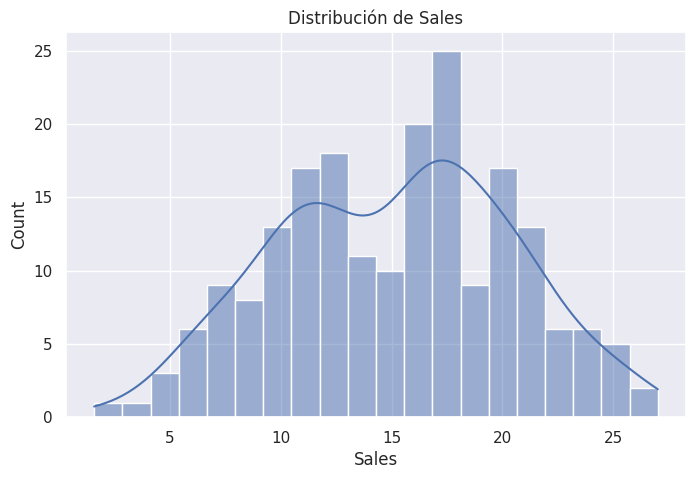

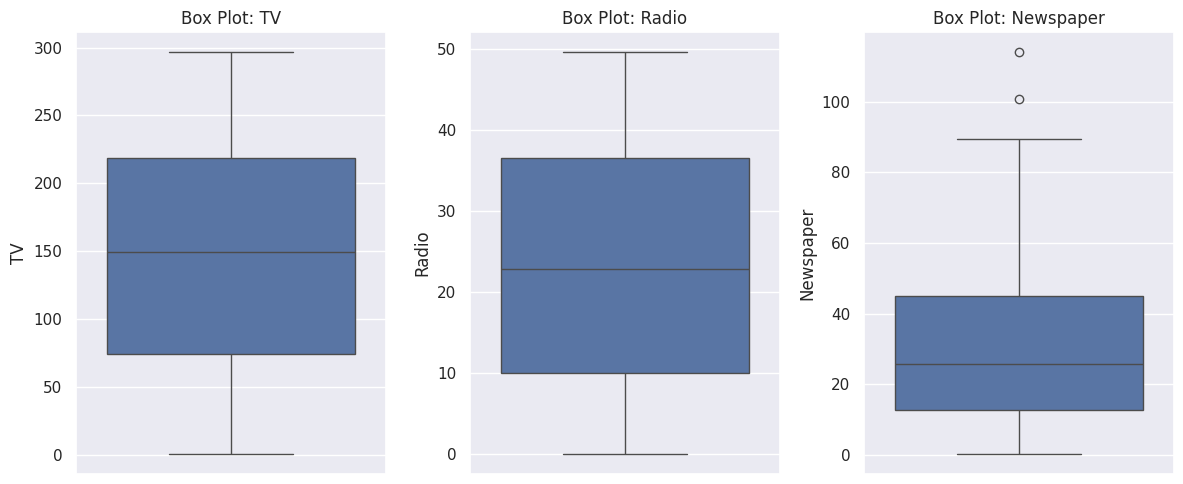

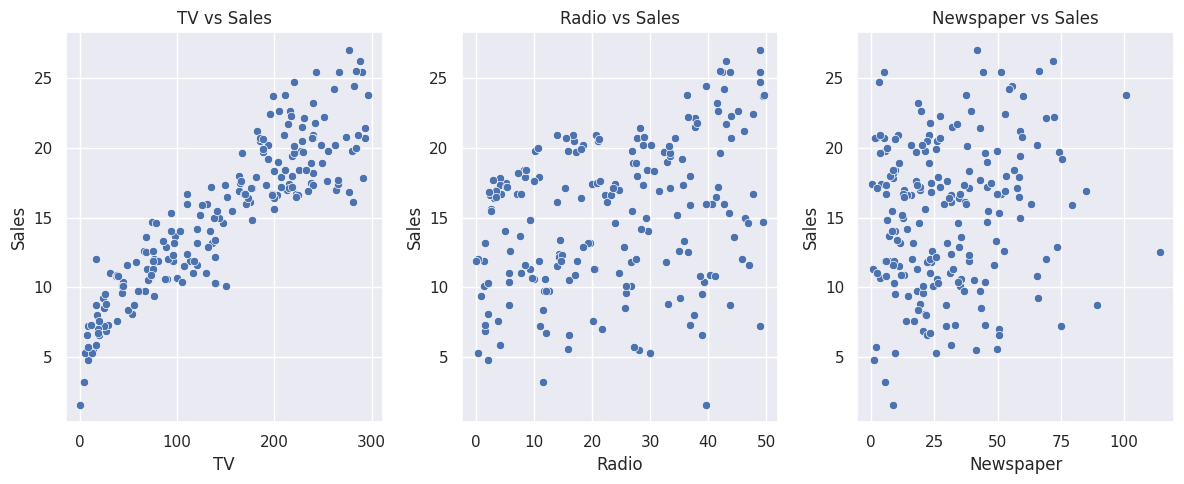

In [31]:
# Llamo a la función general del análisis gráfico
graph_analysis(df, TARGET_COL, FEATURE_COLS)

La distribución de la variable de ventas (variable target) presenta una distribución que se aproxima a la normal con algunas anomalías en el centro de la campana.

Si nos fijamos en los gráficos de caja, tanto *TV* como *Radio* tienen distribuciones normales con las cajas centradas entre los bigotes superior e inferior sin presencia de datos atípicos. Sin embargo la variable *Newspaper* tendría una distribución normal sesgada hacea sus valores bajos (con el centro desplazado hacia la izquierda) y la presencia de dos valores atípicos encima del bigote superior.

Finalmente, en cuanto a los gráficos de dispersión para ver la relación de la variable target con el resto de características, vemos que *Newspaper* no guarda ningún tipo de relación lineal con la variable *Sales*. La variable *Radio* tampoco guarda esta relación líneal, aunque está más cerca de guardarla que la anterior, tiene los valores demasiado dispersos por el gráfico. Sin embargo la característica *TV* tiene una clara relación lineal con la variable objetivo, pudiendo aproximarse de una manera muy decente con una recta.

### **Análisis de Correlación (Pearson)**

Analizaremos ahora el coeficiente de correlación de Pearson de la variable target con el resto de características.

In [32]:
def corr_pearson(df: pd.DataFrame):
  """
  Función para sacar un análisis de correlación de Pearson
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """
  # Con llamar a la función de la matriz de correlacion dentro de la funcion del mapa de calor basta
  corr_heatmap(get_corr_matrix(df))

def get_corr_matrix(df: pd.DataFrame):
  """
  Función para sacar la matriz de correlación de Pearson
  :param df: DataFrame con los datos
  :return: Matriz de correlación de Pearson
  """
  corr_matrix = df.corr(method="pearson")

  print("\nMatriz de correlación de Pearson:")
  print(corr_matrix)

  return corr_matrix

def corr_heatmap(corr_matrix: pd.DataFrame):
  """
  Función para sacar por pantalla un mapa de calor de correlación
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """

  plt.figure(figsize=(7, 6))
  sns.heatmap(
      corr_matrix,
      annot= True,
      fmt= ".2f",
      cmap= "coolwarm",
      cbar=True,
      linewidth= 0.5,
      linecolor= "black"
  )
  plt.title("Mapa de calor de la correlación de Pearson")
  plt.show()


Matriz de correlación de Pearson:
                 TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.901208
Radio      0.054809  1.000000   0.354104  0.349631
Newspaper  0.056648  0.354104   1.000000  0.157960
Sales      0.901208  0.349631   0.157960  1.000000


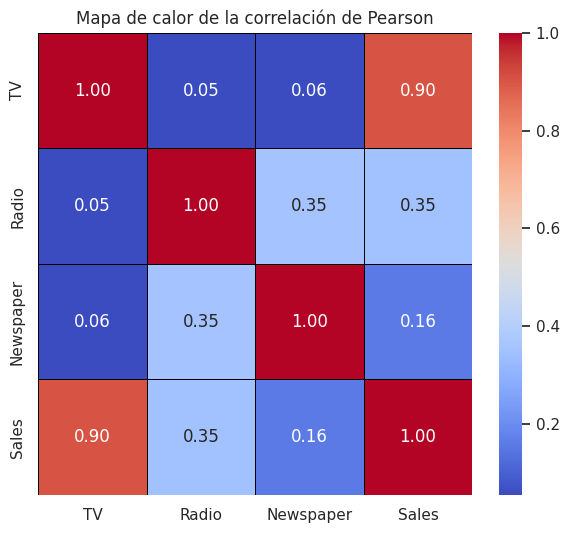

In [33]:
# Ejecuto la función de arriba
corr_pearson(df)

Como habíamos anticipado con las gráficas de dispersión, se confirma una fuerte correlación positiva entre la variable *TV* y la variable target.

Además ya podríamos haber sabido que era positiva porque la pendiente que dibuja la recta imaginaria que siguen estas dos variables en el gráfico de dispersión también es, a su vez, positiva.

Sin embargo, vemos la falta de linealidad entre el resto de características con valores de correlación más bajos, 0.35 y 0.16 respectivamente.

## **2. Entrenamiento de modelos de Regresión Lasso y Ridge**

### **Train/Test Split**

Debido a que tenemos pocas muestras en ese set de datos (200) haremos una separación de 80% para entrenamiento (160 muestras) y 20% para test (40 muestras), así nos aseguramos de que tiene suficientes muestras para entrenarse.

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURE_COLS],
    df[TARGET_COL],
    test_size= 0.2,
    random_state= 42
)

# Comprobamos el tamaño de los sets
print(f"\nTamaño de Train: {X_train.shape}")
print(f"\nTamaño de Test: {X_test.shape}")


Tamaño de Train: (160, 3)

Tamaño de Test: (40, 3)


### **Regresión Ridge**
Utilizaré `GridSearchCV` con 5-Fold CV para encontrar el valor óptimo de alpha que minimice el Error Cuadrático Medio negativo (ya que GridSearchCV maximiza el score).

In [35]:
# Defino los alphas que serán comunes para los dos modelos
alphas = np.logspace(-10, 3, 400)

# Búsqueda del alpha óptimo para Ridge
ridge_params = {'alpha': alphas}
ridge_cv = GridSearchCV(
    Ridge(random_state=42),
    ridge_params,
    cv= 5,
    scoring= "neg_mean_squared_error",
    n_jobs= -1
)
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_
best_alpha_ridge = ridge_cv.best_params_["alpha"]
ridge_cv_score = ridge_cv.best_score_

### **Regresión Lasso**

In [36]:
# Búsqueda del alpha óptimo para Lasso
lasso_path = {"alpha": alphas}
lasso_cv = GridSearchCV(
    Lasso(random_state=42),
    lasso_path,
    cv= 5,
    scoring= "neg_mean_squared_error",
    n_jobs= -1
)
lasso_cv.fit(X_train, y_train)
best_lasso = lasso_cv.best_estimator_
best_alpha_lasso = lasso_cv.best_params_["alpha"]
lasso_cv_score = lasso_cv.best_score_

### **Resultados de la búsqueda del mejor Alpha**

In [37]:
print("\n--- Resultados de Búsqueda de Alpha con 5-Fold CV ---")
print(f"\nMejor Alpha (Lasso): {best_alpha_lasso}")
print(f"MSE CV Promedio (Lasso): {lasso_cv_score:.4f}")

print(f"\nMejor Alpha (Ridge): {best_alpha_ridge:}")
print(f"MSE CV Promedio (Ridge): {ridge_cv_score:.4f}")


--- Resultados de Búsqueda de Alpha con 5-Fold CV ---

Mejor Alpha (Lasso): 1e-10
MSE CV Promedio (Lasso): -2.7402

Mejor Alpha (Ridge): 279.3285250948247
MSE CV Promedio (Ridge): -2.7399


Podemos apreciar que el modelo de regresión Ridge tiene un **error cuadrático medio mejor**.

El hecho de que en Lasso el alpha sea tan cercano a cero quiere decir que la regularización era prácticamente innecesaria para lograr un buen rendimiento.

> Apunte: He dejado el logspace con esos valores, ya que encontraba un mejor alpha para el modelo lasso del orden de 1e-15, pero esto no mejoraba en nada el error cuadrático medio de este.

## **3. Evaluación en el conjunto de Prueba y Análisis de Coeficientes**

Teniendo el mejor alpha para cada uno de los modelos, se evaluarán en el conjunto de pruebas y se examinaran sus coeficientes para ver el efecto de la regularización.

### **Cálculo de Métricas (MSE y Rcuadrado) en el conjunto de pruebas**

In [38]:
# Predicción en el conjunto de pruebas
y_pred_lasso = best_lasso.predict(X_test)
y_pred_ridge = best_ridge.predict(X_test)

# Métricas Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Métricas Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n--- Métricas en el conjunto de Prueba ---")
print(f"\nLASSO (Alpha={best_alpha_lasso})")
print(f"MSE: {mse_lasso:.4f}")
print(f"R^2: {r2_lasso:.4f}")

print(f"\nRIDGE (Alpha={best_alpha_ridge:.4f})")
print(f"MSE: {mse_ridge:.4f}")
print(f"R^2: {r2_ridge:.4f}")


--- Métricas en el conjunto de Prueba ---

LASSO (Alpha=1e-10)
MSE: 2.9078
R^2: 0.9059

RIDGE (Alpha=279.3285)
MSE: 2.9188
R^2: 0.9055


Analizando estos resultados podemos decir que, ambos modelos funcionan muy bien, con valores de R^2 alrededor del 0.905. Esto quiere decir que los dos explican muy bien el 90.5% de la varianza del target.

Tanto el MSE como el R^2 son casi idénticos:

- Lasso: ´MSE = 2.9078´ ´R^2 = 0.9059´

- Ridge: ´MSE = 2.9188´ ´R^2 = 0.9055´

Se podría decir que Lasso es mejor pero la diferencia es mínima.

### **Análisis de coeficientes**

In [39]:
print("\n--- Coeeficientes de los Modelos Óptimos ---")

# DataFrame para visualizar los coeficientes de manera más sencilla
coef_df = pd.DataFrame({
    'Feature': FEATURE_COLS,
    'Lasso Coef': best_lasso.coef_,
    'Ridge Coef': best_ridge.coef_
})

print(coef_df)


--- Coeeficientes de los Modelos Óptimos ---
     Feature  Lasso Coef  Ridge Coef
0         TV    0.054509    0.054503
1      Radio    0.100945    0.100016
2  Newspaper    0.004337    0.004580


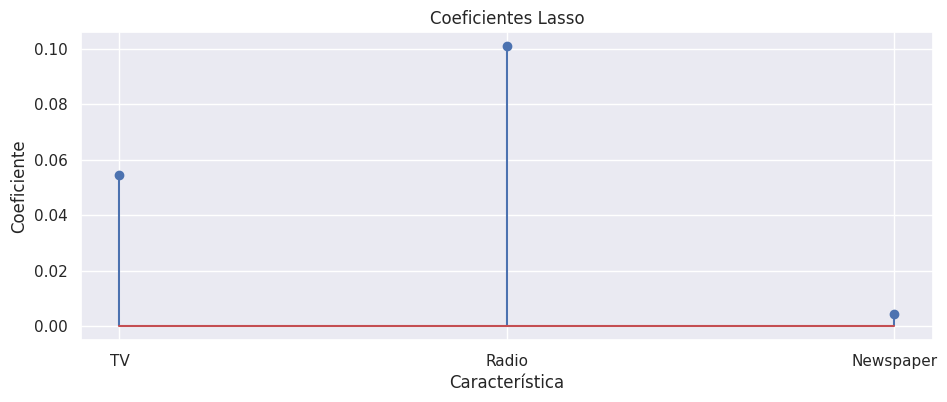

In [40]:
# Gráfico de los coeficientes Lasso optimos
plt.figure(figsize=(11,4))
plt.stem(coef_df['Feature'], coef_df['Lasso Coef'])
ax = plt.gca()
ax.set_xlabel("Característica")
ax.set_ylabel("Coeficiente")
ax.set_title("Coeficientes Lasso")
plt.show()

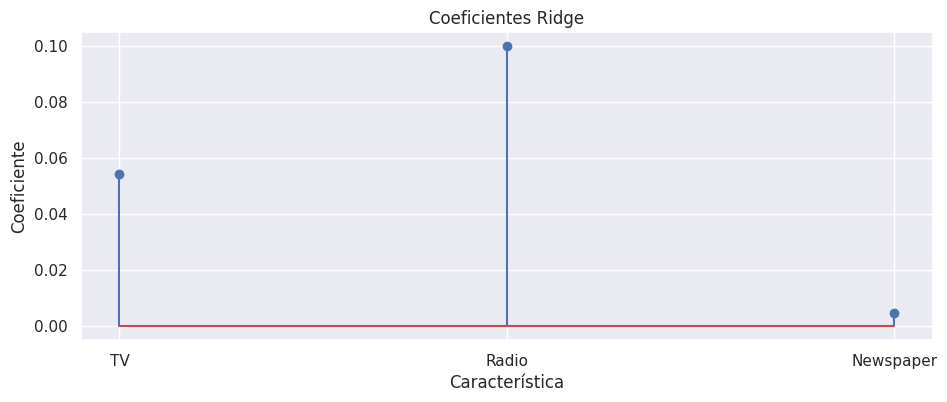

In [41]:
# Gráfico de los coeficientes Ridge optimos
plt.figure(figsize=(11,4))
plt.stem(coef_df['Feature'], coef_df['Ridge Coef'])
ax = plt.gca()
ax.set_xlabel("Característica")
ax.set_ylabel("Coeficiente")
ax.set_title("Coeficientes Ridge")
plt.show()

Vemos que los coeficientes de ambos modelos son muy muy semejantes, pero la naturaleza de Lasso de hacer *Selección de Características*, empuja a Newspaper (la característica menos relevante) más a 0 que el modelo Ridge.

### **Gráficos de Coeficientes en Función de Alpha**

Aquí vamos a ilustrar visualmente cómo el crecimiento de la penalización Alpha hace que los coeficientes se reduzcan.

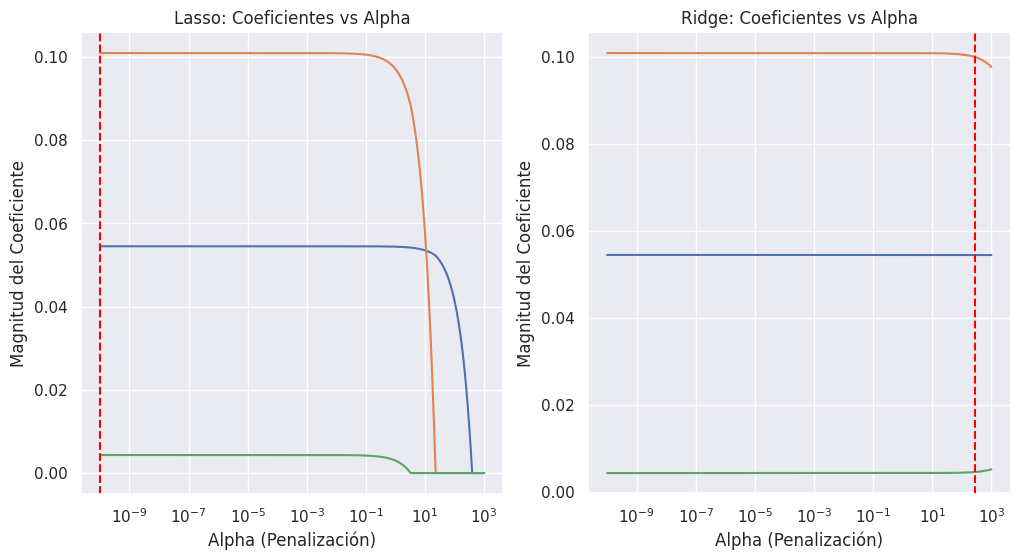

In [42]:
# Variables para el plot
coefs_lasso = []
coefs_ridge = []
alphas = np.logspace(-10, 3, 1000) # Mismo rango que en la CV

# Cálculo de los coeficientes
for alpha in alphas:
  # Lasso
  lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42) # limito el número de iteraciones
  lasso.fit(X_train, y_train)
  coefs_lasso.append(lasso.coef_)

  # Ridge
  ridge = Ridge(alpha=alpha, random_state=42)
  ridge.fit(X_train, y_train)
  coefs_ridge.append(ridge.coef_)

# Cambio a np.array para visualización
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Gráficos
plt.figure(figsize=(12, 6))

# Gráfico Lasso
plt.subplot(1, 2, 1)
ax1 = plt.gca()
for i in range(coefs_lasso.shape[1]):
  # ploteo cada coeficiente para cada característica con un determinado alpha
  ax1.plot(alphas, coefs_lasso[:, i], label=FEATURE_COLS[i])
ax1.set_xscale("log") # escala logarítmica para mejor visualización
plt.xlabel("Alpha (Penalización)")
plt.ylabel("Magnitud del Coeficiente")
plt.title("Lasso: Coeficientes vs Alpha")
plt.axvline(x=best_alpha_lasso, color="red", linestyle="--", label="Mejor Alpha (Lasso)")

# Gráfico Ridge
plt.subplot(1, 2, 2)
ax1 = plt.gca()
for i in range(coefs_ridge.shape[1]):
  # ploteo cada coeficiente para cada característica con un determinado alpha
  ax1.plot(alphas, coefs_ridge[:, i], label=FEATURE_COLS[i])
ax1.set_xscale("log") # escala logarítmica para mejor visualización
plt.xlabel("Alpha (Penalización)")
plt.ylabel("Magnitud del Coeficiente")
plt.title("Ridge: Coeficientes vs Alpha")
plt.axvline(x=best_alpha_ridge, color="red", linestyle="--", label="Mejor Alpha (Ridge)")

plt.show()

+ **Lasso**: al aumentar el factor Alpha, los coeficientes disminuyen bruscamente y algunos se reducen a cero, realizando la selección de variables de la que hablábamos. Favorece modelos más simples y fáciles de interpretar.

+ **Ridge**: Los coeficientes también se reducen con Alpha, pero **nunca llegan a 0**. Aplica una regularización suave, útil para controlar el sobreajuste y manejar la **multicolinealidad**.

## **5. Discusión Teórica y Conclusiones**

### Explicando la Regularización y sus Ventajas

La **regularización** es una técnica utilizada para prevenir el **sobreajuste (overfitting)** al añadir un término de penalización a la función de coste (MSE).

### **¿Cómo afecta la regularización?**

- **Minimización de Coeficientes**: El modelo ya no solo busca minimizar el error de ajuste a los datos, sino también la magnitud de sus propios coeficientes. Esto quiere decir que si un coeficiente intenta volverse muy grande (lo que a menudo indica overfitting o un ajuste excesivo al ruido), el término de penalización (Alpha) lo empuja de nuevo a 0.

- **Reducción de Varianza**: Al limitar los coeficientes, se reduce la complejidad y la varianza del modelo, haciéndolo más generalizable a datos no vistos antes. Esto se hace a costa de introducir un pequeño sesgo por defecto.

### **Ventajas en Casos Específicos**

1. **Sobreajuste (Overfitting)**: Como ya hemos comentado, al restringir la magnitud de coeficientes, se evita que el modelo aprenda demasiado del ruido en los datos de entrenamiento.

2. **Multicolinealidad** Cuando dos caracteríisticas esán altamente correlacionadas, la regresión lineal estándar puede asignar coeficientes grandes y opuestos a ellas, volviéndose inesstable. La regularización mitiga esto:

- **Ridge**: Estabiliza el modelo repartiendo el peso entre las **features** correlacionadas.

- **Lasso**: Tiende a seleccionar solo una de las característicasz correlacionadas y establecer la otra en 0.

## **6. Conclusiones generales**

En general, ambos modelos funcionan muy bien en este dataset. Remarcar que no existe mucha multicolinealidad ni exceso de características, son unos datos muy sencillos y explicables.

Aún así podríamos decir que por la naturaleza de los datos funciona mejor el modelo Lasso que con un Alpha muy bajo consigue los mismos coeficientes prácticamente que el modelo Ridge al que le hace falta un alpha mucho más grande.
